In [1]:
#https://huggingface.co/blog/controlnet
#https://blog.shikoan.com/controlnet_lora/
!pip install --upgrade pip --quiet
!pip install --upgrade torchvision --quiet
!pip install --upgrade torch --quiet
!pip install diffusers transformers xformers git+https://github.com/huggingface/accelerate.git --quiet
!pip install opencv-contrib-python --quiet
!pip install controlnet_aux --quiet
!pip install mediapipe --quiet

In [2]:
!pip list |grep torch

open-clip-torch                     2.19.0
pytorch-lightning                   2.0.2
torch                               2.0.1
torchmetrics                        0.11.4
torchvision                         0.15.2
torchviz                            0.0.2


In [3]:
from diffusers.utils import load_image

imgs = []

for i in range(1, 5):
    image = load_image(
        f"https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/yoga{i}.jpeg",
    )
    imgs.append(image)

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector
import torch
from PIL import Image
import numpy as np


device = "cuda:0"

# Detect poses
pose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
poses = []

for i in range(0, 4):
    p = pose_detector(imgs[i])
    poses.append(p)

# Load control net
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "andite/anything-v4.0", controlnet=controlnet, torch_dtype=torch.float16
    )
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# Disabling safety checker
if pipe.safety_checker is not None:
    pipe.safety_checker = lambda images, **kwargs: (images, False)
pipe.to(device)

# run stable diffusion
images = []
generator = torch.Generator(device)
prompt = "1girl, masterpiece, best quality, extremely detailed, 4K, illustration"
negative_prompt = "low quality, worst quality, bad fingers, bad face, extra arms, extra legs"
for i in range(3):
    generator.manual_seed(i+1024)
    image = pipe([prompt]*4, poses, negative_prompt=[negative_prompt]*4, generator=generator,
                num_inference_steps=50, output_type="numpy").images
    images.append(image)
images = (np.concatenate(images, axis=0) * 255.0).astype(np.uint8)
# Concatenate images
h, w, c = images.shape[1:]
images = images.reshape(3, 4, h, w, c).swapaxes(1, 2).reshape(3*h, 4*w, c)
with Image.fromarray(images) as img:
    img.save("result.jpg", quality=90)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

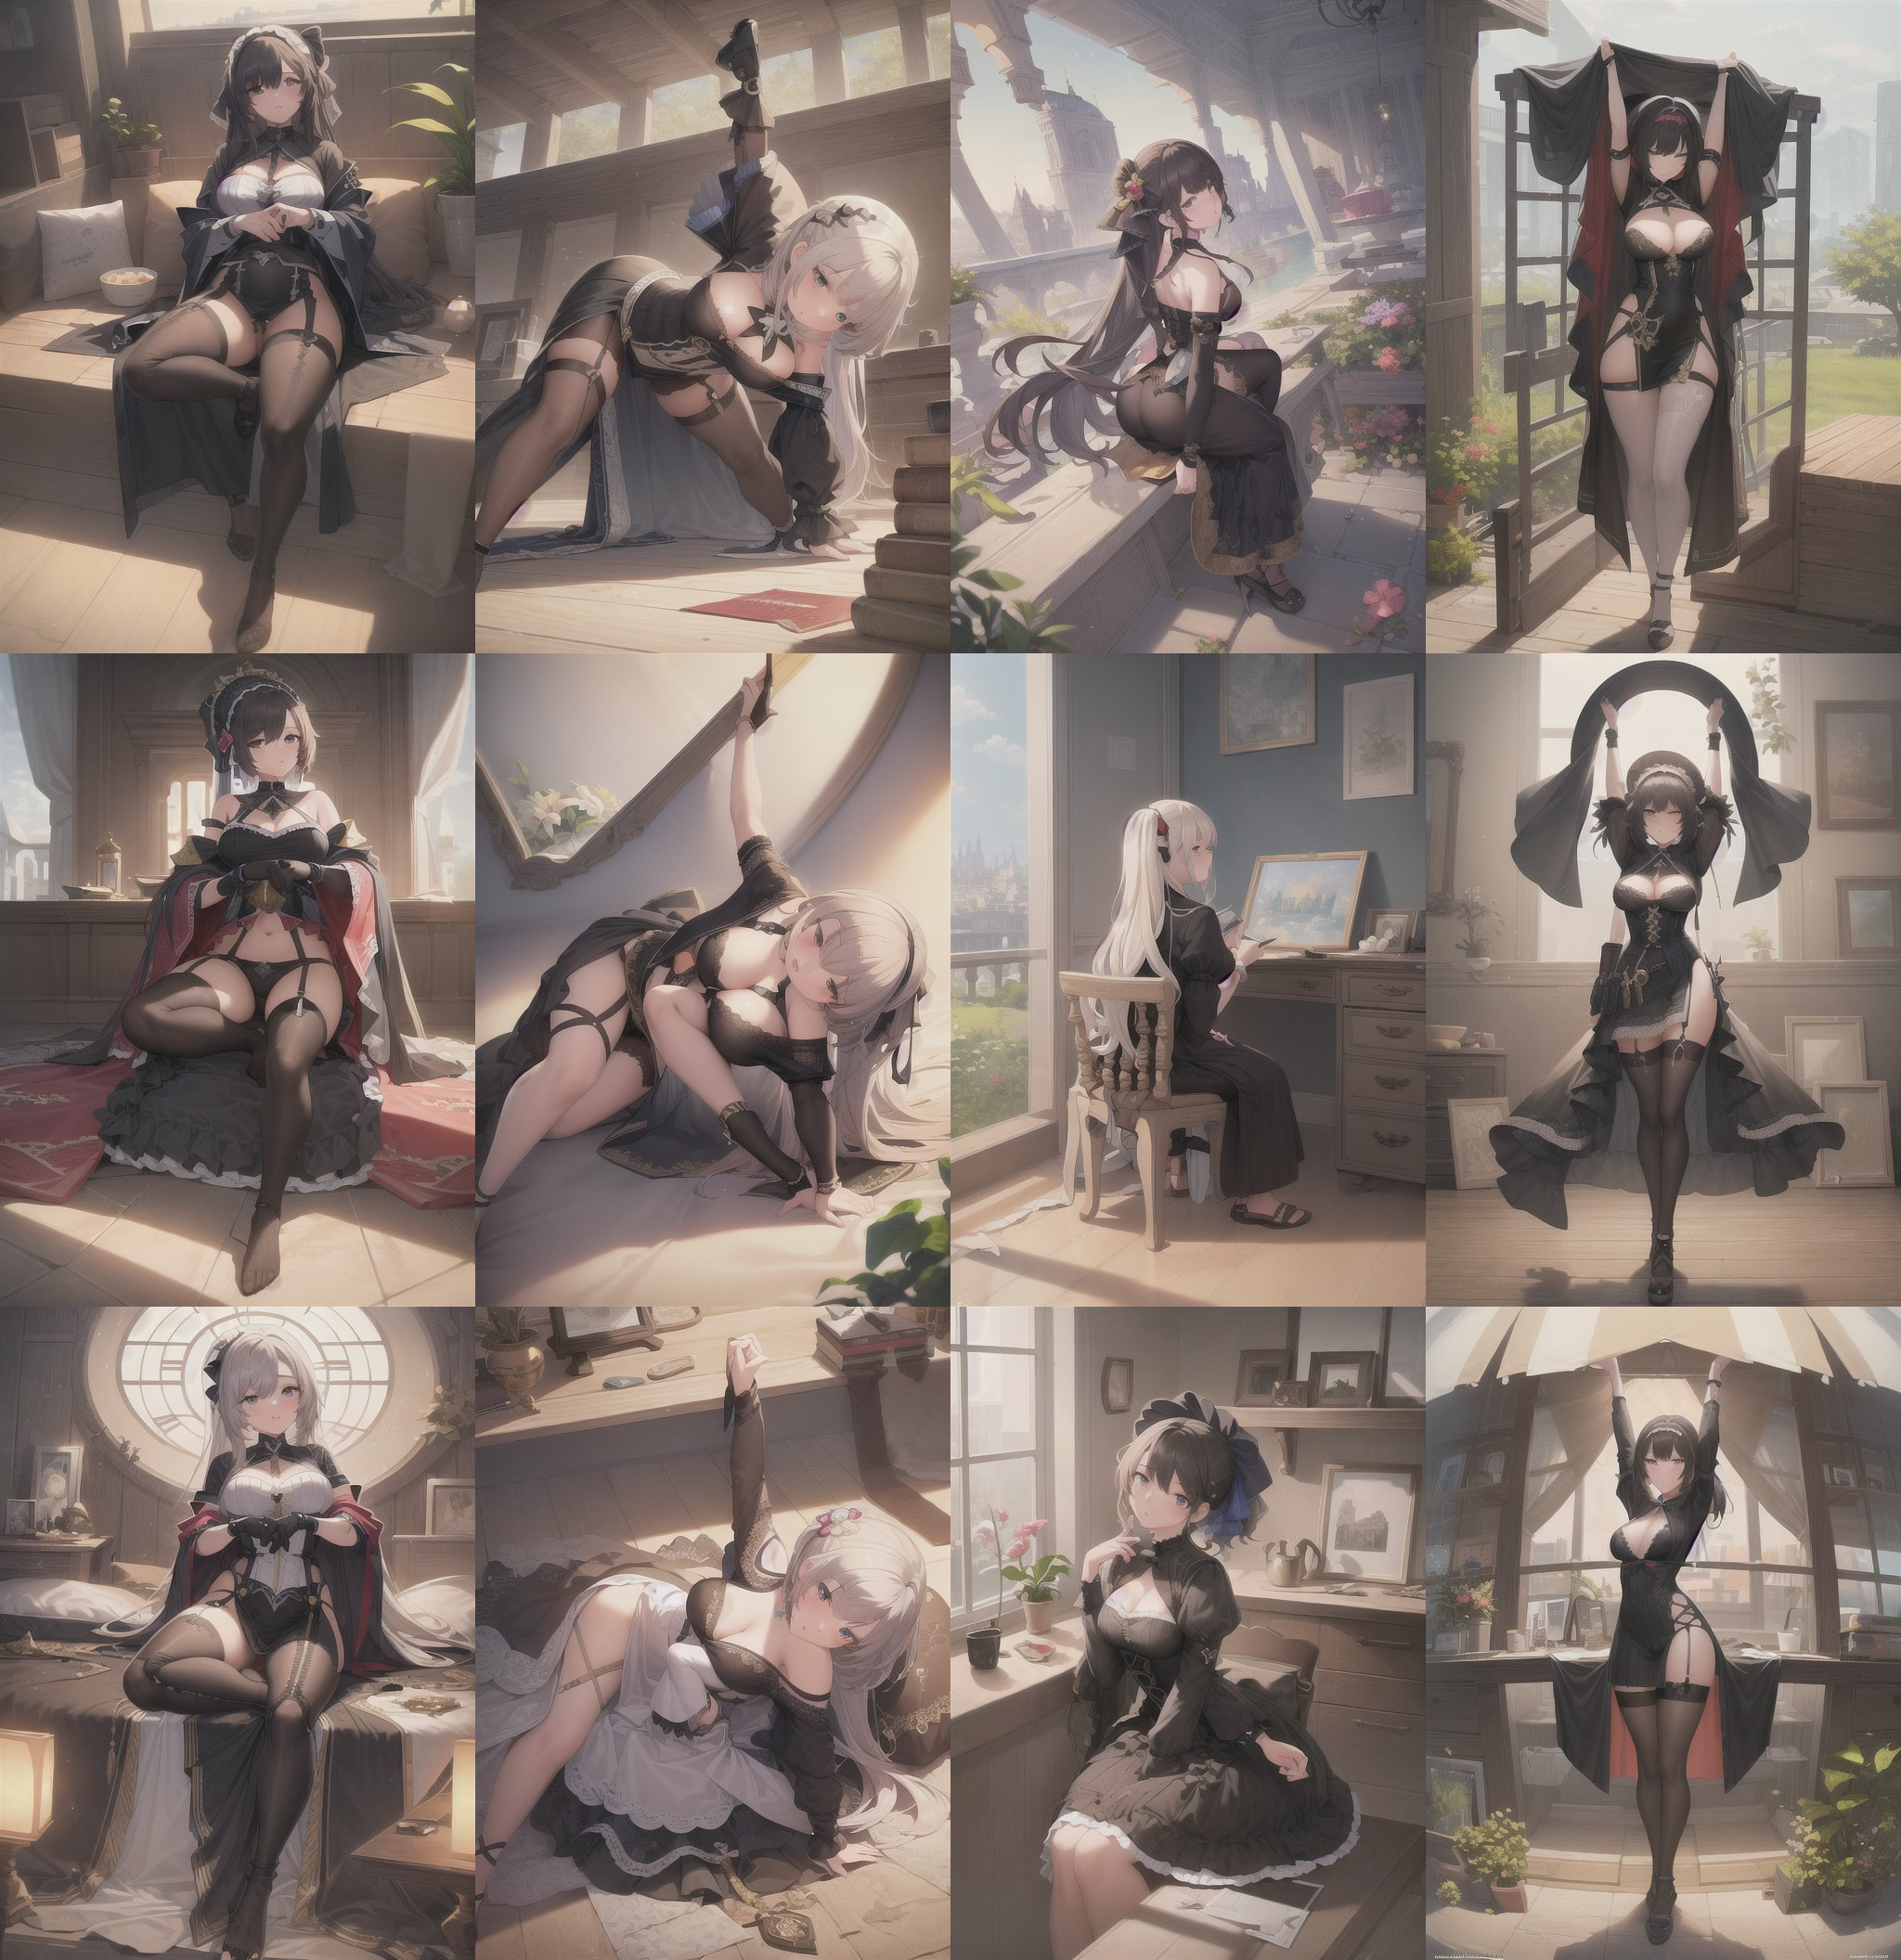

In [4]:
from PIL import Image

image = Image.open("result.jpg")
image.show()

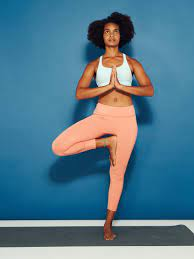

In [5]:
imgs[0]